In [54]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import Normalize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from math import floor
import seaborn as sn
import pandas as pd
import numpy as np
import pickle
import string
import nltk
import re
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding
from nltk.tokenize import word_tokenize

connect to google drive

In [55]:
from google.colab import drive
drive.mount("/content/drive/")
%cd drive/MyDrive

In [58]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import fasttext

read data and fasttext model

In [60]:
model = fasttext.load_model("cc.fa.300.bin")
data = pd.read_csv("classification.csv")
data["label"] = data["label"].apply(lambda x: 1 if x == "رسمی" else 0)

tfidf of words in text

In [61]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["sentence"])

In [62]:
feature_names = vectorizer.get_feature_names()
scores = X.toarray()

at first we normalized sentence then the word embeding of each word is calculating and multiple by tfidf 

In [63]:
tfidf = []
train_vectors = []
temp = 10  
for i, sentence in (enumerate(data["sentence"])):
  sentence = re.sub(r'[^\u0621-\u06CC\s]+', ' ', sentence)
  x = "'ًٌٍُِْ'"
  for pm in x:
    sentence = sentence.replace(pm,'')
  
  for pm in ['?',',','.','!','(',')','<','>']:
    sentence = sentence.replace(pm,' ')
  tf=[]
  first_sentence_words =sentence.split()
  first_sentence_scores = scores[i]
  tfidf_scores = {feature_names[j]: first_sentence_scores[j] for j in range(len(feature_names)) if feature_names[j] in first_sentence_words}
  
  for word in first_sentence_words:
      try:
          tf.append(tfidf_scores[word]* model.get_word_vector(word))
      except:
        ''
  tfidf.append(tf)

In [64]:
final_vectores=np.array(tfidf)

<ipython-input-64-b2e70f0725ee>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_vectores=np.array(tfidf)


seperate train and test data

In [65]:
train_text, test_text, train_labels, test_labels = train_test_split(final_vectores, data['label'], test_size=0.2, random_state=42)

In [66]:
train_text=np.array(train_text)

In [67]:
import tensorflow as tf

add zero padding

In [84]:
def padarray(A, size):
    t = size - len(A)
    if(t>0):
      A = np.pad(A, ((0,t),(0,0)), 'constant', constant_values=(0,0))
    return A[:24]

X_train=[]
maxsize = 24
for i in (range(len(train_text))):
  X_train.append(padarray(train_text[i], 24)) 


In [85]:
X_test=[]
maxsize = 24
for i in (range(len(test_text))):
  X_test.append(padarray(test_text[i], 24)) 


In [86]:
X_test=np.array(X_test)
X_train = np.array(X_train)

In [87]:
X_train = tf.convert_to_tensor(X_train)

In [73]:
train_labels = tf.convert_to_tensor(np.array(train_labels)) 

In [74]:
y_test=tf.convert_to_tensor(np.array(test_labels)) 

In [76]:
train_labels=np.array(train_labels)
train_labels[train_labels==1]=True
train_labels[train_labels==0]=False

training the model

In [88]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define the dimensions of your data
samples = 16000
timesteps = 24
features = 300

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, features)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the data
history = model.fit(X_train, train_labels, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 12s 52ms/step - loss: 0.4325 - accuracy: 0.7984 - val_loss: 0.3472 - val_accuracy: 0.8428
Epoch 2/10
200/200 [==============================] - 8s 39ms/step - loss: 0.3341 - accuracy: 0.8537 - val_loss: 0.3361 - val_accuracy: 0.8444
Epoch 3/10
200/200 [==============================] - 10s 51ms/step - loss: 0.3150 - accuracy: 0.8577 - val_loss: 0.3108 - val_accuracy: 0.8403
Epoch 4/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2949 - accuracy: 0.8658 - val_loss: 0.2949 - val_accuracy: 0.8487
Epoch 5/10
200/200 [==============================] - 12s 59ms/step - loss: 0.2824 - accuracy: 0.8670 - val_loss: 0.2797 - val_accuracy: 0.8581
Epoch 6/10
200/200 [==============================] - 10s 50ms/step - loss: 0.2740 - accuracy: 0.8681 - val_loss: 0.2740 - val_accuracy: 0.8581
Epoch 7/10
200/200 [==============================] - 9s 44ms/step - loss: 0.2617 - accuracy: 0.8725 - val_loss: 0.2749 - val_accuracy: 0.

saving model

In [89]:
import pickle

with open('fasttext.pickle', 'wb') as handle:
    pickle.dump(model, handle)

In [90]:
preperd_data = np.array([X_test[:]])
preperd_data = preperd_data.reshape((-1,24,300))

In [91]:
def CM_drawer(array):
  df_cm = pd.DataFrame(array)
  sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

125/125 [==============================] - 5s 25ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1957
           1       0.87      0.85      0.86      2043

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000

[[1706  251]
 [ 312 1731]]


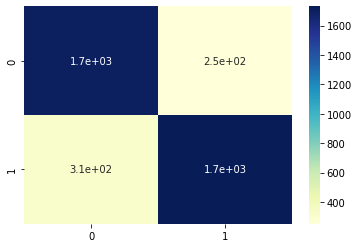

In [92]:
predict = model.predict(preperd_data)
th = 0.5
predict[predict>th]=1
predict[predict<1]=0
# a

print(classification_report(y_test[:], predict))
cm = confusion_matrix(y_test[:], predict)
print(cm)
CM_drawer(cm)